In [ ]:
import random
import numpy as np
import pandas as pd

random.seed(0)
np.random.seed(0)
pd.set_option("display.max_rows", 300)

In [ ]:
HUMAN = "human"

GEMINI_10 = "gemini-1.0-pro"
GEMINI_15 = "gemini-1.5-pro-latest"

CLAUDE_SONNET = "claude-3-sonnet-20240229"
CLAUDE_OPUS = "claude-3-opus-20240229"

GPT_35 = "gpt-3.5-turbo-0125"
GPT_40 = "gpt-4-turbo-2024-04-09"

LLMS = [GEMINI_10, GEMINI_15, CLAUDE_SONNET, CLAUDE_OPUS, GPT_35, GPT_40]
AUTHORS = LLMS + [HUMAN]

REDDIT = "reddit"
HEWLETT = "hewlett"
DATASETS = [REDDIT, HEWLETT]

# Function words

In [ ]:
with open("function_words/oshea.txt") as f:
    lines = f.readlines()
    fw_oseah = [line.split()[0] for line in lines]

# Z-Scores

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import word_tokenize
from scipy.spatial.distance import cdist
from sklearn.feature_extraction.text import TfidfVectorizer


class ZScoreTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, fw):
        self.fw = fw
        self.vectorizer = TfidfVectorizer(
            use_idf=False, norm=None, tokenizer=word_tokenize, token_pattern=None
        )
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        # Fit the vectorizer to the corpus
        word_counts = self.vectorizer.fit_transform(X).toarray()

        # Save the function words and their indicies if they are in the vocabulary
        self.used_fw = [word for word in self.fw if word in self.vectorizer.vocabulary_]
        self.used_fw_indices = [
            self.vectorizer.vocabulary_[word] for word in self.used_fw
        ]

        # Fit z-score scaler to the relative frequencies
        relative_freqs = word_counts / word_counts.sum(axis=1, keepdims=True)
        self.scaler.fit(relative_freqs)
        return self

    def transform(self, X):
        # Transform the corpus into word counts
        word_counts = self.vectorizer.transform(X).toarray()

        # Calculate the relative frequencies
        relative_freqs = word_counts / word_counts.sum(axis=1, keepdims=True)

        # Calculate the z-scores
        z_scores = self.scaler.transform(relative_freqs)[:, self.used_fw_indices]

        return z_scores

    def get_used_fw(self):
        return self.used_fw

# Deltas

In [ ]:
def delta(z_scores, variant):
    if variant == "burrows":
        return cdist(z_scores, z_scores, metric="cityblock")
    if variant == "cosine":
        return cdist(z_scores, z_scores, metric="cosine")

    raise ValueError(f"Unknown variant: {variant}")

# Classification

In [ ]:
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


def classify(
    df,
    function_words,
    test_prompts=None,
    return_df_coefs=False,
    df_test_include_text=False,
):
    # Train-test split
    prompt_ids = df["prompt_id"].unique().tolist()
    if not test_prompts:
        test_prompts = random.sample(prompt_ids, 2)

    df_test = df[df["prompt_id"].isin(test_prompts)].reset_index(drop=True)
    df_train = df[~df["prompt_id"].isin(test_prompts)].reset_index(drop=True)

    # Use the ZScoreTransformer to get the z-scores
    z_scores_transformer = ZScoreTransformer(function_words)
    z_scores_train = z_scores_transformer.fit_transform(df_train["text"])
    z_scores_test = z_scores_transformer.transform(df_test["text"])

    # Set up cross-validation
    train_indices_by_prompt = (
        df_train.groupby("prompt_id")
        .apply(lambda x: x.index, include_groups=False)
        .tolist()
    )
    cv_iterable = []
    for _ in range(3):
        train_indices_by_prompt = (
            train_indices_by_prompt[2:] + train_indices_by_prompt[:2]
        )
        val_indices = np.concatenate(train_indices_by_prompt[:2])
        train_indices = np.concatenate(train_indices_by_prompt[2:])
        cv_iterable.append((train_indices, val_indices))

    # Train the model using grid search
    model = GridSearchCV(
        LogisticRegression(max_iter=1000),
        param_grid={
            "C": [0.001, 0.003, 0.01, 0.03, 0.1],
            "solver": ["liblinear", "lbfgs"],
        },
        cv=cv_iterable,
        n_jobs=-1,
        refit=True,
    )

    model.fit(z_scores_train, df_train["author"])
    y_pred = model.predict(z_scores_test)

    df_test["author_pred"] = y_pred
    if not df_test_include_text:
        df_test = df_test.drop(columns=["text"])

    # print the words that were most important for the model
    if return_df_coefs:
        coefs = model.best_estimator_.coef_.squeeze()
        used_fw = z_scores_transformer.get_used_fw()
        df_coefs = pd.DataFrame({"word": used_fw, "coef": coefs})
        return df_test, df_coefs

    else:
        return df_test

In [ ]:
################## TEST ##################


# df_human = pd.read_csv(f"{REDDIT}/responses/{HUMAN}.csv")
# df_human["author"] = HUMAN
# df_llm = pd.read_csv(f"{REDDIT}/responses/{GPT_35}.csv")
# df_llm["author"] = GPT_35
# df = pd.concat([df_human, df_llm]).reset_index(drop=True)

# df_test, df_coefs = classify(df, fw_oseah, return_df_coefs=True)

# Binary classification

In [ ]:
N_TRIALS = 30
fw = fw_oseah

if False:
    binary_classification = []
    for dataset in DATASETS:
        df_human = pd.read_csv(f"{dataset}/responses/{HUMAN}.csv")
        df_human["author"] = HUMAN
        for llm in LLMS:
            df_llm = pd.read_csv(f"{dataset}/responses/{llm}.csv")
            df_llm["author"] = llm
            df = pd.concat([df_human, df_llm], ignore_index=True)
            for trial in tqdm(range(N_TRIALS), desc=f"{dataset} {llm}"):
                df_test, df_coefs = classify(df, fw_oseah, return_df_coefs=True)

                binary_classification.append(
                    {
                        "dataset": dataset,
                        "llm": llm,
                        "trial": trial,
                        "df_test": df_test.to_json(orient="records"),
                        "df_coefs": df_coefs.to_json(orient="records"),
                    }
                )

    df_binary_classification = pd.DataFrame(binary_classification)
    df_binary_classification.to_csv(f"results/binary_classification.csv", index=False)

  dataset                       llm  accuracy  family
0  reddit    claude-3-opus-20240229  0.837333  claude
1  reddit  claude-3-sonnet-20240229  0.853250  claude
2  reddit            gemini-1.0-pro  0.940417  gemini
3  reddit     gemini-1.5-pro-latest  0.903750  gemini
4  reddit        gpt-3.5-turbo-0125  0.907333     gpt
5  reddit    gpt-4-turbo-2024-04-09  0.932417     gpt


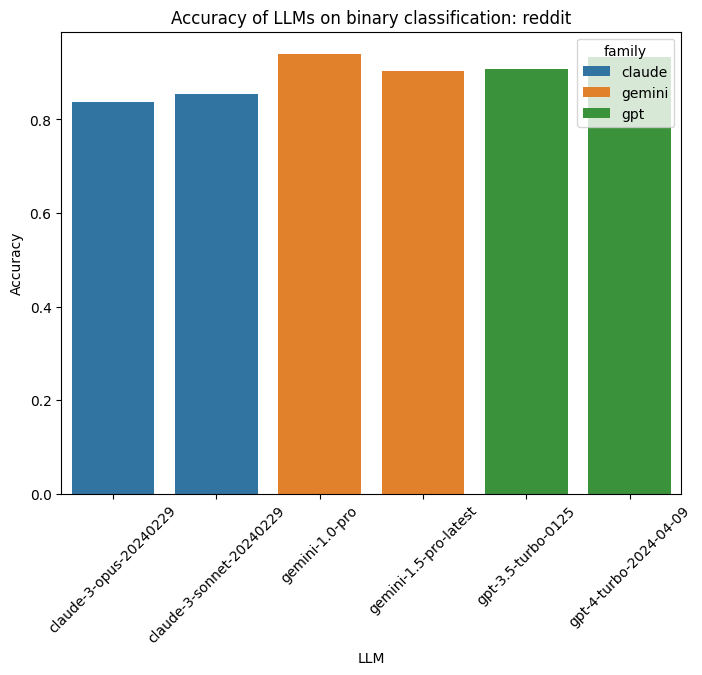

   dataset                       llm  accuracy  family
0  hewlett    claude-3-opus-20240229  0.861583  claude
1  hewlett  claude-3-sonnet-20240229  0.835083  claude
2  hewlett            gemini-1.0-pro  0.917167  gemini
3  hewlett     gemini-1.5-pro-latest  0.927417  gemini
4  hewlett        gpt-3.5-turbo-0125  0.942833     gpt
5  hewlett    gpt-4-turbo-2024-04-09  0.949917     gpt


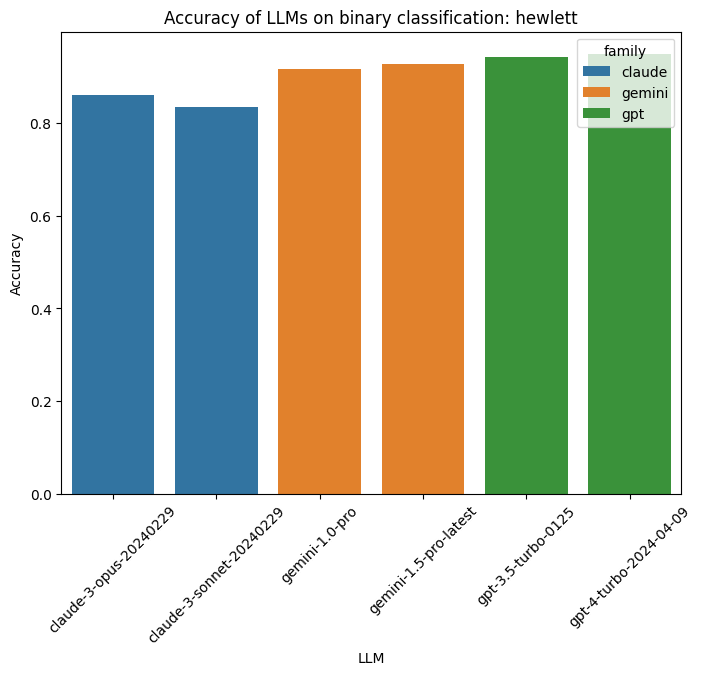

In [45]:
from io import StringIO


df_bin = pd.read_csv("results/binary_classification.csv")
for dataset in DATASETS:
    df_bin_dataset = df_bin[df_bin["dataset"] == dataset]
    df_acc = []
    for _, dataset, llm, _, df_test, _ in df_bin_dataset.itertuples():
        df_test = pd.read_json(StringIO(df_test), orient="records")
        acc = (df_test["author"] == df_test["author_pred"]).mean()
        df_acc.append({"dataset": dataset, "llm": llm, "accuracy": acc})
    df_acc = pd.DataFrame(df_acc)
    df_acc = df_acc.groupby(["dataset", "llm"]).mean().reset_index()
    df_acc["family"] = df_acc["llm"].apply(lambda x: x.split("-")[0])
    print(df_acc)

    plt.figure(figsize=(8, 6))
    sns.barplot(data=df_acc, x="llm", y="accuracy", hue="family")
    plt.title(f"Accuracy of LLMs on binary classification: {dataset}")
    plt.ylabel("Accuracy")
    plt.xlabel("LLM")
    plt.xticks(rotation=45)
    plt.show()

## Most important words

For each LLM and dataset, rank the words by their coefficient in the LR model (rankings are averaged over N_TRIALS trials).

In [ ]:
from io import StringIO


N = 10
fw = fw_oseah

df_binary_classification = pd.read_csv("results/binary_classification.csv")

df_coefs_list = []
for _, dataset, llm, _, _, df_coefs in df_binary_classification.itertuples():
    df_coefs = pd.read_json(StringIO(df_coefs))
    df_coefs["dataset"] = dataset
    df_coefs["llm"] = llm
    df_coefs["coef_abs"] = np.abs(df_coefs["coef"])
    df_coefs["coef_sign"] = np.sign(df_coefs["coef"])

    # Add a row for each word that is in fw but not in the df
    fw_used = set(df_coefs["word"].values)
    new_rows = []
    for word in fw:
        if word not in fw_used:
            new_rows.append(
                {
                    "dataset": dataset,
                    "llm": llm,
                    "word": word,
                    "coef_abs": 0,
                    "coef_sign": 0,
                }
            )

    df_new_rows = pd.DataFrame(new_rows)
    df_coefs = pd.concat([df_coefs, df_new_rows], ignore_index=True)

    # Compute ranks (use average rank for ties)
    df_coefs["rank"] = df_coefs.groupby(["dataset", "llm"])["coef_abs"].rank(
        method="average", ascending=False
    )
    df_coefs_list.append(df_coefs)

df_coefs = pd.concat(df_coefs_list, ignore_index=True)
df_avg_ranks = df_coefs.groupby(["dataset", "llm", "word"]).mean().reset_index()
df_n_smallest = df_avg_ranks.groupby(["dataset", "llm"]).apply(
    lambda x: x.nsmallest(N, "rank"), include_groups=False
)
df_n_smallest

## Word frequencies

Ratio between the frequency of each word between the LLMs and humans. 

In [ ]:
# get the 10 words with the smallest average rank across all datasets and llms
N = 10
df_coefs_mult = df_coefs.copy()
n_most_important = (
    df_coefs[["word", "rank"]].groupby("word").mean().abs().sort_values("rank").head(10)
)
n_most_important

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator


pronouns = [
    "he",
    "him",
    "his",
    "himself",
    "she",
    "her",
    "hers",
    "herself",
    "they",
    "them",
    "their",
    "theirs",
    "themselves",
]

high_coef_words = n_most_important.index.tolist()

for words in [pronouns, high_coef_words]:
    # Read the data and compute ratios for each dataset
    for dataset in DATASETS:
        ratios = []
        for word in words:
            df_human = pd.read_csv(f"{dataset}/responses/{HUMAN}.csv")
            human_word_counts = df_human["text"].str.count(word)
            human_word_freq = human_word_counts / df_human["text"].apply(
                lambda x: len(x.split())
            )
            human_word_avg_freq = human_word_freq.mean()

            for llm in LLMS:
                df_llm = pd.read_csv(f"{dataset}/responses/{llm}.csv")
                llm_word_counts = df_llm["text"].str.count(word)
                llm_word_freq = llm_word_counts / df_llm["text"].apply(
                    lambda x: len(x.split())
                )
                llm_word_avg_freq = llm_word_freq.mean()

                ratio = (
                    llm_word_avg_freq / human_word_avg_freq
                    if human_word_avg_freq
                    else 100
                )
                ratios.append({"word": word, "llm": llm, "ratio": ratio})

        ratios_df = pd.DataFrame(ratios)
        pivot_df = ratios_df.pivot(index="word", columns="llm", values="ratio")
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            pivot_df,
            cmap="coolwarm",
            annot=True,
            fmt=".2f",
            norm=LogNorm(vmin=1 / 10, vmax=10),
        )
        plt.title(f"LLM/Human Word Frequency Ratios: {dataset.capitalize()}")
        plt.xlabel("LLM")
        plt.ylabel("Word")
        plt.show()

# Multiclass classification (all 7 authors)

In [ ]:
n_trials = 1

if True:
    multiclass_classification = []
    for dataset in DATASETS:
        dfs = []
        for author in AUTHORS:
            df = pd.read_csv(f"{dataset}/responses/{author}.csv")
            df["author"] = author
            dfs.append(df)
        df = pd.concat(dfs, ignore_index=True)

        for trial in tqdm(range(n_trials), desc=f"Running {dataset} trials"):
            df_test = classify(df, fw_oseah)
            multiclass_classification.append(
                {
                    "dataset": dataset,
                    "trial": trial,
                    "df_test": df_test.to_json(orient="records"),
                }
            )
    df_multiclass_classification = pd.DataFrame(multiclass_classification)
    df_multiclass_classification.to_csv(
        "results/multiclass_classification.csv", index=False
    )

In [ ]:
df_multi = pd.read_csv("results/multiclass_classification.csv")

for dataset in DATASETS:
    df_multi_cur = df_multi[df_multi["dataset"] == dataset]
    cms = []
    for df_test in df_multi_cur["df_test"]:
        df_test = pd.read_json(StringIO(df_test), orient="records")
        cm = confusion_matrix(df_test["author"], df_test["author_pred"])
        cms.append(cm)
    avg_conf_matrix = np.mean(cms, axis=0)

    sns.heatmap(
        avg_conf_matrix,
        annot=True,
        cmap="YlGnBu",
        fmt=".1f",
        cbar_kws={
            "label": "Number of Predictions",
            "boundaries": np.arange(0, 201, 1),
            "ticks": np.arange(0, 201, 50),
        },
        xticklabels=AUTHORS,
        yticklabels=AUTHORS,
    )
    plt.title(f"Average Confusion Matrix: {dataset.capitalize()} dataset")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## Pairwise with human and each LLM

# Mis-labels: GPT 3.5, human

In [ ]:
n_trials = 10

for dataset in ["reddit", "hewlett"]:
    df_human = pd.read_csv(f"{dataset}_responses/human.csv")
    df_human["author"] = HUMAN
    df_gpt_35 = pd.read_csv(f"{dataset}_responses/{GPT_35}.csv")
    df_gpt_35["author"] = GPT_35
    df = pd.concat([df_human, df_gpt_35], ignore_index=True)

    llm_predicted_human = {}
    human_predicted_llm = {}

    for _ in tqdm(range(n_trials)):
        prompts = list(range(8))
        random.shuffle(prompts)
        test_prompts_list = [prompts[:2], prompts[2:4], prompts[4:6], prompts[6:8]]

        for test_prompts in test_prompts_list:
            df_test = classify(df, function_words=fw_oseah, test_prompts=test_prompts)

            for prompt in test_prompts:
                df_human_predicted_llm = df_test[
                    (df_test["author"] == HUMAN)
                    & (df_test["y_pred"] == GPT_35)
                    & (df_test["prompt_id"] == prompt)
                ]
                if not df_human_predicted_llm.empty:
                    llm_predicted_human[prompt] = df_human_predicted_llm.iloc[0]["text"]

                df_llm_predicted_human = df_test[
                    (df_test["author"] == GPT_35)
                    & (df_test["y_pred"] == HUMAN)
                    & (df_test["prompt_id"] == prompt)
                ]
                if not df_llm_predicted_human.empty:
                    human_predicted_llm[prompt] = df_llm_predicted_human.iloc[0]["text"]

    print(f"Dataset: {dataset}")
    for prompt in range(8):
        print(f"Prompt: {prompt}")
        if prompt in llm_predicted_human:
            print(f"Human predicted LLM: {llm_predicted_human[prompt]}")
        else:
            print("Human predicted LLM: N/A")
        if prompt in human_predicted_llm:
            print(f"LLM predicted human: {human_predicted_llm[prompt]}")
        else:
            print("LLM predicted human: N/A")
        print()
    print("\n" * 3)

## GPT 3.5 Temperatures

In [ ]:
n_trials = 10
temps = [f"{0.1 * i:.1f}" for i in range(14)]

for dataset in ["reddit", "hewlett"]:
    df_word_ranks = []
    for temp in tqdm(temps * n_trials):
        df_human = pd.read_csv(f"{dataset}_responses/human.csv")
        df_human["author"] = HUMAN
        df_temp = pd.read_csv(f"{dataset}_responses/{GPT_35}_{temp}.csv")
        df_temp["author"] = GPT_35
        df = pd.concat([df_human, df_temp], ignore_index=True)

        df_test = classify(df, fw_oseah)
        report = classification_report(
            df_test["author"], df_test["y_pred"], zero_division=0, output_dict=True
        )
        df_word_ranks.append(
            {
                "dataset": dataset,
                "temp": temp,
                "accuracy": report["accuracy"],
            }
        )

    results_df = pd.DataFrame(df_word_ranks)

    plt.figure(figsize=(8, 6))
    sns.lineplot(data=results_df, x="temp", y="accuracy")
    plt.title(
        f"Human vs. GPT-3.5 Binary Classifier over a range of temperatures: {dataset.capitalize()} dataset"
    )
    plt.ylabel("Accuracy")
    plt.xlabel("Temperature")
    plt.show()

# t-SNE

## All prompts

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

for dataset in ["reddit", "hewlett"]:
    dfs = []
    for author in authors:
        df = pd.read_csv(f"{dataset}_responses/{author}.csv")
        df["author"] = author
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)

    z_scores_transformer = ZScoreTransformer(function_words=fw_oseah)
    z_scores = z_scores_transformer.fit_transform(df["text"])

    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(z_scores)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df["author"])
    plt.title(f"t-SNE Visualization of all prompts: {dataset.capitalize()} dataset")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

## Individual prompts

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

for dataset in ["reddit", "hewlett"]:
    for prompt_id in range(8):
        dfs = []
        for author in authors:
            df = pd.read_csv(f"{dataset}_responses/{author}.csv")
            df["author"] = author
            dfs.append(df)
        df = pd.concat(dfs, ignore_index=True)
        df = df[df["prompt_id"] == prompt_id]

        z_scores_transformer = ZScoreTransformer(function_words=fw_oseah)
        z_scores = z_scores_transformer.fit_transform(df["text"])

        tsne = TSNE(n_components=2, random_state=42)
        X_tsne = tsne.fit_transform(z_scores)

        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df["author"])
        plt.title(
            f"t-SNE Visualization of prompt {prompt_id} in the {dataset.capitalize()} dataset"
        )
        plt.xlabel("t-SNE Dimension 1")
        plt.ylabel("t-SNE Dimension 2")
        plt.show()